Kernel trick主要用在無法線性分離的資料集上。我們可以藉由一個映射$\phi:\mathbb{R}^d\to\mathbb{R}^k$ $(k>>d)$，來讓升高維度後的資料集能夠線性分離。假設$\mathbf{x}^{(i)},\mathbf{x}^{(j)}$為兩個樣本，常用的核有以下幾種：

(1) 徑向基函數核(高斯核)，又稱rbf
$$\kappa(\mathbf{x}^{(i)},\mathbf{x}^{(j)})=\exp\bigg(-\frac{\|\mathbf{x}^{(i)}-\mathbf{x}^{(j)}\|^2}{2\sigma^2}\bigg)$$
(2) 雙曲正切核(sigmoid)
$$\kappa(\mathbf{x}^{(i)},\mathbf{x}^{(j)})=\tanh(\eta\mathbf{x}^{(i)T}\mathbf{x}^{(j)}+\theta)$$
(3) 多項式核(poly)
$$\kappa(\mathbf{x}^{(i)},\mathbf{x}^{(j)})=(\mathbf{x}^{(i)T}\mathbf{x}^{(j)}+\theta)^p$$
然後我們定義$\textbf{核矩陣}\mathbf{K}$為 $$\mathbf{K}=[\kappa(\mathbf{x}^{(i)},\mathbf{x}^{(j)})]_{n\times n}$$
省略詳細的數學推導，我們直接以現成的Python code實作kernel trick

In [29]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, i]
                            for i in range(n_components)))

    return X_pc

(甲) 半月形資料的分離:
為了顯示PCA在無法線性分離的資料集有多麼沒用，我們直接用看看PCA分離資料(甲)

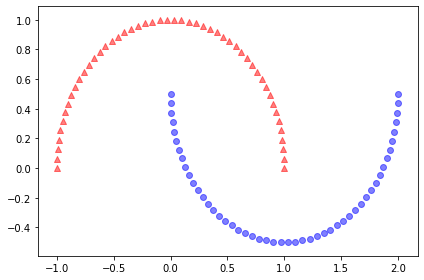

In [30]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_12.png', dpi=300)
plt.show()

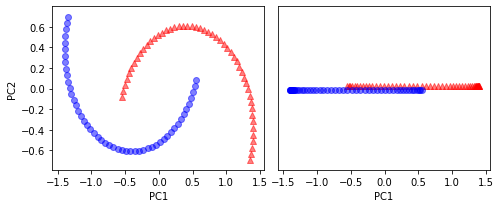

In [31]:
from sklearn.decomposition import PCA # 試著用PCA分離之

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_13.png', dpi=300)
plt.show()

全部擠在同一條線上!實在是無能為力，我們來看看自己手刻的kernel trick成效如何?

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


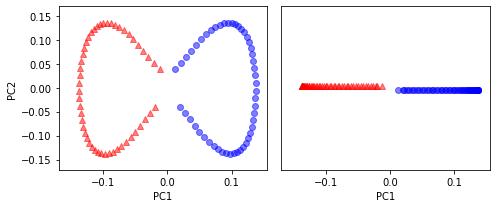

In [32]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_14.png', dpi=300)
plt.show()

這樣一來便十分漂亮，可以輕鬆的用一條線分開來。

(乙) 同心圓資料的分離

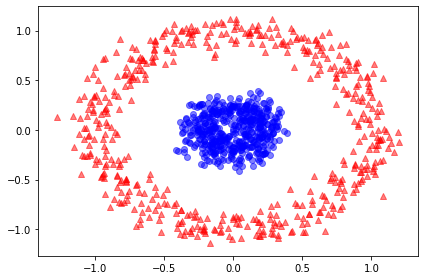

In [33]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_15.png', dpi=300)
plt.show()

用PCA分看看

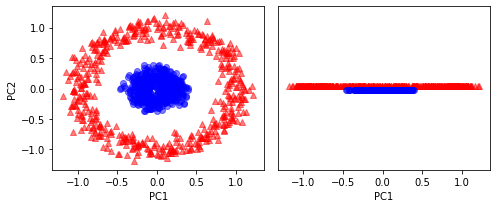

In [34]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

也是一樣全部擠在同一條線上，接著我們試試看kernel trick

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


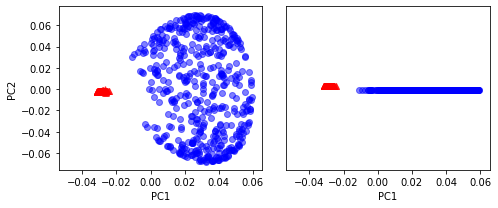

In [35]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()

總而言之，kernel trick就是把數據集投影到一個新的空間裡。問題在於，如何投影那些本來不在數據集的點呢?(比方說只投影了訓練集，那測試集???)經過不可描述的數學過程，我們可以重新手刻一個kernel trick演算法。

In [36]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     alphas: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset 
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, i]
                              for i in range(n_components)))

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


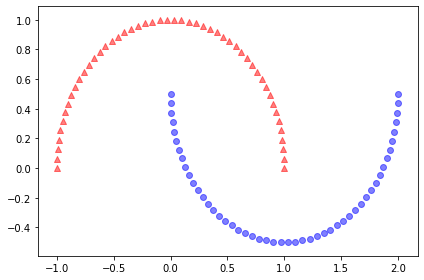

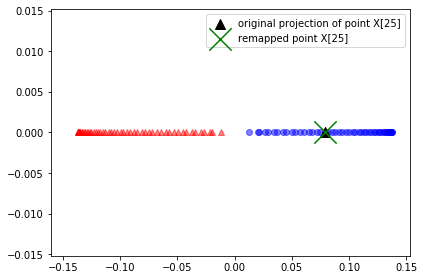

In [37]:
X, y = make_moons(n_samples=100, random_state=123) # 製作半月形資料集
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1) # 引用我們手刻的kernel trick

# 繪製原始的半月形資料集
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

x_new = X[25] # 假設第26筆數據是新的數據點
x_proj = alphas[25] # original projection

# 定義投影函數
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)

# 繪製投影後的數據集
plt.scatter(alphas[y == 0, 0], np.zeros((50)),color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()

最後，偉大的scikit-learn當然也有幫我們實作一個kernel trick，名子就叫做kernelPCA。將來遇到非線性可分離的資料集，可以放心使用。

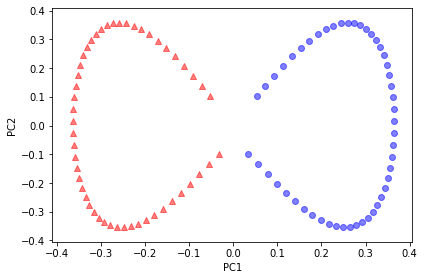

In [38]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()